*Kirill Semenov, bkl162*

# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

## For Google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading all we need

In [2]:
!pip install sentencepiece

In [0]:
import torch
from torch import nn
from torch import functional as F

import torchtext
from torchtext.datasets import WikiText2
from torchtext import data

import numpy as np

import sentencepiece as spm

In [4]:
WikiText2.download('.')

'./wikitext-2/wikitext-2'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


##Setting Hyperparams

In [0]:
VOCAB_SIZE = 16000
BATCH_SIZE = 512
HIDDEN_SIZE = 512
BPTT_LEN = 50
N_EPOCHS = 50

checkpoint = 'rnn_lm.pt'

In [6]:
spm.SentencePieceTrainer.Train('--input=wikitext-2/wikitext-2/wiki.train.tokens --model_prefix=spm --vocab_size='+str(VOCAB_SIZE))

True

In [7]:
sp = spm.SentencePieceProcessor()
sp.Load("spm.model")

True

In [0]:
TEXT = torchtext.data.Field(lower=True, tokenize=sp.EncodeAsPieces)

In [0]:
train, valid, test = torchtext.datasets.WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train, max_size=VOCAB_SIZE+10)

## Tricking out BPTT

In [0]:
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN,
    device=device,
    repeat=False)

## Model

In [0]:
class RnnWithHeadLM(nn.Module):

    def __init__(self, ntoken, ninp,
                 nhid, nlayers,
                 dropout=0.5, tie_weights=True):
      
        super().__init__()

        self.nhid, self.nlayers = nhid, nlayers
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.RNN(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.hidden = None
 
    def forward(self, input, hidden=None):

        hidden = self.hidden if hidden is None else hidden
        emb = self.drop(self.encoder(input))

        output, hidden = self.rnn(emb, hidden)
        self.hidden = hidden 

        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))

        v = decoded.view(output.size(0), output.size(1), decoded.size(1))
        return v
  
    def reset_history(self):

        if self.hidden is None:
            return None
            
        self.hidden = self.hidden.data

In [13]:
model = RnnWithHeadLM(VOCAB_SIZE, HIDDEN_SIZE, HIDDEN_SIZE, 1)
model.to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


RnnWithHeadLM(
  (drop): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(16000, 512)
  (rnn): RNN(512, 512, dropout=0.5)
  (decoder): Linear(in_features=512, out_features=16000, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
def train_epoch(epoch):
    tr_history = []
    tr_loss = 0
    model.train()
    
    for batch in train_iter:
      model.reset_history()
      optimizer.zero_grad()

      text, targets = batch.text, batch.target
      prediction = model(text)
      loss = criterion(prediction.view(-1, VOCAB_SIZE), targets.view(-1))
      loss.backward()

      optimizer.step()

      tr_history.append(loss.item())
      tr_loss += loss.item() * prediction.size(0) * prediction.size(1)

    tr_loss /= len(train.examples[0].text)

    val_loss = 0
    model.eval()
    for batch in valid_iter:
        model.reset_history()
        text, targets = batch.text, batch.target
        prediction = model(text)
        loss = criterion(prediction.view(-1, VOCAB_SIZE), targets.view(-1))
        val_loss += loss.item() * prediction.size(0) * prediction.size(1)
    val_loss /= len(valid.examples[0].text)

    return tr_loss, tr_history, val_loss

In [0]:
checkpoint = None

In [0]:
if checkpoint is not None:
    check = torch.load(checkpoint)
    model.load_state_dict(check['model'])
    optimizer.load_state_dict(check['optimizer'])
    tr_history = check['tr_history']
    val_history = check['val_history']
    epoch = check['epoch']
else:
    tr_history = []
    val_history = []
    epoch = 0

In [20]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

for epoch in range(epoch, N_EPOCHS): 
    tr_loss, tr_hist, val_loss = train_epoch(epoch)
    tr_history += tr_hist
    val_history += [val_loss] 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'tr_history': tr_history,
        'val_history': val_history,
        'epoch': epoch+1,
    }, 'drive/My Drive/rnn_lm.pt')

    clear_output()
    print(f'Epoch: {epoch}, Training Loss: {tr_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch: 49, Training Loss: 3.8876, Validation Loss: 3.6586


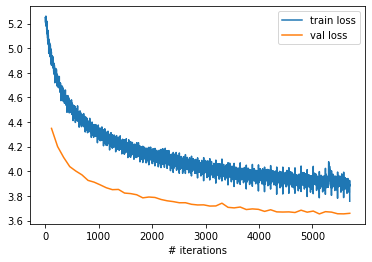

In [21]:
from matplotlib import pyplot as plt

plt.plot(tr_history, label='train loss')
plt.plot([(i+1)*len(tr_hist) for i in range(len(val_history))], val_history, label='val loss')
plt.xlabel('# iterations')
plt.legend()

## Generation

In [0]:
context_strs = ['East Asia was one of the cradles of world civilization, with China, an ancient East Asian civilization being one of the earliest cradles of civilization in human history.',
                'Though not commonly used today, half-dollar coins have a long history of heavy use alongside other denominations of coinage, but have faded out of general circulation for many reasons.',
                'Parliament approved the agreement for further scrutiny, but rejected passing it into law before 31 October deadline, and forced the government to ask for a third Brexit delay.',
                'Ireland ranks among the top ten wealthiest countries in the world in terms of GDP per capita, and as the tenth most prosperous country in the world according to The Legatum Prosperity Index 2015.',
                'His musical talent was obvious at an early age, and he was harshly and intensively taught by his father Johann van Beethoven, who thought this would enable him to become a child prodigy like Mozart.']

In [0]:
context_pieces = [sp.EncodeAsPieces(x) for x in context_strs]

In [0]:
context_ids = [[TEXT.vocab.stoi[s] for s in x] for x in context_pieces]

inps = [torch.LongTensor(x).unsqueeze(1).to(device) for x in context_ids]

In [0]:
def sample_sequence(model, context, sample_method, continuation_length=150):
    continuation_length = context.size(0)
    past = context
    model.hidden = None

    out = model(past.to(device))
    next_token = sample_method(out[-1, :, :])
    gen = next_token
    past = torch.cat([past, next_token], 0)
    for _ in range(continuation_length-1):
        if next_token.item() == TEXT.vocab.stoi['<eos>']:
          break
        out = model(next_token)
        next_token = sample_method(out[-1, :, :])
        past = torch.cat([past, next_token], 0)
        gen = torch.cat([gen, next_token], 0)
    return past, gen

In [0]:
def continue_strs(inps, sample_method):
    for i, inp in enumerate(inps):
        str_gen = ""
        while len(str_gen.split()) < 20:
            cat, gen = sample_sequence(model, inp, sample_method)
            str_gen = sp.DecodePieces([TEXT.vocab.itos[i] for i in gen[:, 0].tolist()])
        print('Context: ', context_strs[i])
        print('Continuation: ', sp.DecodePieces([TEXT.vocab.itos[i] for i in gen[:, 0].tolist()]))
        print()

## Argmax

## top-k sampling

In [0]:
def top_k_top_p_sampling(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(nn.functional.softmax(sorted_logits, dim=-1), dim=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return torch.multinomial(torch.exp(logits), 1)

In [28]:
for k in [3, 5, 8, 10, 14, 20]:
    print(f'\n=== k = {k} ===\n')
    method = lambda x: top_k_top_p_sampling(x, top_k=k)
    continue_strs(inps, method)


=== k = 3 ===

Context:  East Asia was one of the cradles of world civilization, with China, an ancient East Asian civilization being one of the earliest cradles of civilization in human history.
Continuation:  s . in the early 1990s , the airline was also known as the national highway system . the highway was built in a large number of around the <unk> . the 

Context:  Though not commonly used today, half-dollar coins have a long history of heavy use alongside other denominations of coinage, but have faded out of general circulation for many reasons.
Continuation:  s. cruzi , and <unk> . <unk> , these is <unk> and <unk> , and <unk> <unk> , <unk> , and the

Context:  Parliament approved the agreement for further scrutiny, but rejected passing it into law before 31 October deadline, and forced the government to ask for a third Brexit delay.
Continuation:  <unk> . in the late 1960s , the airlines were around the battle . the 766th was held by the▁british army , and also <unk

Context: 

## Sampling with Temperature

In [0]:
def temperature_sampling(logits, t=1.0):
    return top_k_top_p_sampling(logits * (1 / t), top_p=1.0)

In [30]:
for t in [0.5, 0.7, 0.8, 0.95]:
    print(f'\n=== t = {t} ===\n')
    method = lambda x: temperature_sampling(x, t=t)
    continue_strs(inps, method)


=== t = 0.5 ===

Context:  East Asia was one of the cradles of world civilization, with China, an ancient East Asian civilization being one of the earliest cradles of civilization in human history.
Continuation:  <unk> and <unk> . these are a <unk> or <unk> . their body is a <unk> , the <unk> , <

Context:  Though not commonly used today, half-dollar coins have a long history of heavy use alongside other denominations of coinage, but have faded out of general circulation for many reasons.
Continuation:  <unk> , <unk> <unk> ( <unk> ) , which is also known as the <unk> , <unk> <unk> , <unk>

Context:  Parliament approved the agreement for further scrutiny, but rejected passing it into law before 31 October deadline, and forced the government to ask for a third Brexit delay.
Continuation:  <unk> <unk> , and the city of the new▁york▁yankees . the university of the university of the national museum of the <unk> of the archaeolog

Context:  Ireland ranks among the top ten wealthiest countri

## Nucleus Sampling

In [31]:
for p in [0.3, 0.7, 0.9, 0.96]:
    print(f'\n=== p = {p} ===\n')
    method = lambda x: top_k_top_p_sampling(x, top_p=p)
    continue_strs(inps, method)


=== p = 0.3 ===

Context:  East Asia was one of the cradles of world civilization, with China, an ancient East Asian civilization being one of the earliest cradles of civilization in human history.
Continuation:  the church of▁scientology , which was not known as the <unk> . the city 's officials were designed by the new▁york state , and a new state highway system .<eos>

Context:  Though not commonly used today, half-dollar coins have a long history of heavy use alongside other denominations of coinage, but have faded out of general circulation for many reasons.
Continuation:  s. <unk> , and <unk> , <unk> , and <unk> , and <unk> , and the <unk> <unk> <unk> , <

Context:  Parliament approved the agreement for further scrutiny, but rejected passing it into law before 31 October deadline, and forced the government to ask for a third Brexit delay.
Continuation:  they of the two days . the ships were to <unk> to the north . the storm was constructed by the storm .<eos>

Context:  Ireland 